# Enoncé

1. Transformer le code d'apprentissage de la séance 01 en une librairie.
2.  Coder une fonction d'erreur quadratique moyenne entre une prédiction et la vraie cible.
3. Etudier la dépendance de l'erreur par rapport
     - à la distribution des points de l'échantillon (par exemple uniforme ou équirépartis)
     - La loi du bruit.
     - Le degrés du polynôme.
4. Comment pouvons nous estimer l'erreur commise à partir de l'échantillon et sans la cible?
5. Trouvez une alternative au modèle polynomial.

# Question 1

On les objets suivants:
- La cible.
- L'échantillon.
- Le modèle.
- Le prédicteur.

On aura besoin de fonctions qui
- Génère l'affichage à partir de: cible, échantillon, prédicteur.
- Crée l'échantillon à partir de la cible.
- Génère le meilleur prédicteur à partir de l'échantillon et du modèle.

In [1]:
import lib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
cible = lib.Cible(
    fonction=lambda x: np.exp(1. / (2. + np.sin(5 * x) * np.cos(20 * x))),
    gauche=0.,
    droite=0.95,
)

In [4]:
echantillon = lib.genere_echantillon(
    cible=cible, 
    nb_points=20, 
    choix_points=lib.Points.uniforme, 
    choix_bruit=lib.Bruit.normale, 
    amplitude=0.1
)

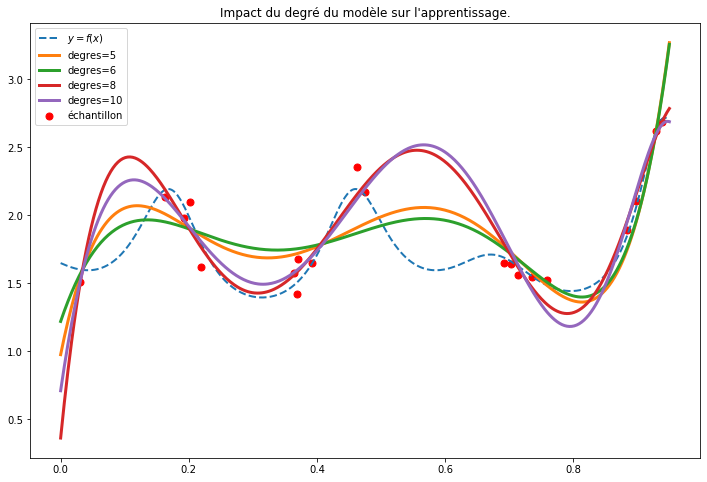

In [5]:
fig, rep = plt.subplots()
rep.set_title("Impact du degré du modèle sur l'apprentissage.")
lib.affichage_cible(cible, rep)
lib.affichage_echantillon(echantillon, repere=rep)
for degre in (5, 6, 8, 10):
    modele = lib.ModelePolynomial(degre)
    modele.entraine(echantillon)
    modele.affichage(cible=cible, repere=rep)
    rep.legend()


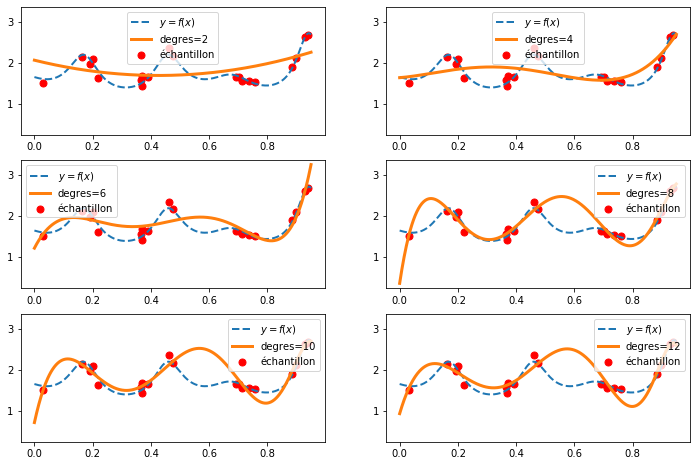

In [6]:
degres = (2, 4, 6, 8, 10, 12)
fig, reps = plt.subplots(nrows=3, ncols=2)

for degre, rep in zip(degres, reps.flatten()):
    lib.affichage_cible(cible, rep)
    lib.affichage_echantillon(echantillon, repere=rep)
    modele = lib.ModelePolynomial(degre)
    modele.entraine(echantillon)
    modele.affichage(cible=cible, repere=rep)
    rep.legend()

lims = [rep.get_ylim() for rep in reps.flatten()]
y_min = min(m for m,_ in lims)
y_max = max(M for _,M in lims)
for rep in reps.flatten():
    rep.set_ylim(y_min, y_max)
    


# Impact de l'échantillon sur un modèle à degrés fixe:

1. Variation du nombre de points
2. Alternative entre uniforme/équirépartis.
3. Alternative entre bruit gaussien/uniforme/sans bruit.


## Variation nombre de points

In [7]:
def etude_points(degres = 10, nbs = (5, 10, 15, 20, 25, 30)):
    modeles = dict()
    echantillons = dict()
    for nb_points in nbs:
        modeles[nb_points] = lib.ModelePolynomial(degres=degres)
        echantillons[nb_points] = lib.genere_echantillon(
            cible=cible, 
            nb_points=nb_points, 
            choix_points=lib.Points.equirepartis,
            choix_bruit=lib.Bruit.uniforme,
            amplitude=0.05,
        )
        modeles[nb_points].entraine(echantillon=echantillons[nb_points])
    
    nb_lignes = round(len(nbs) / 2)
    fig, reps = plt.subplots(nrows=nb_lignes, ncols=2, sharey=True)
    fig.suptitle(f"Etude de l'impact du nombre de points de l'échantillon pour un modèle de degrés {degres}")
    for nb_points, rep in zip(nbs, reps.flatten()):
        lib.affichage_cible(cible=cible, repere=rep)
        lib.affichage_echantillon(echantillon=echantillons[nb_points], repere=rep)
        modeles[nb_points].affichage(repere=rep, cible=cible)
        rep.set_title(f"{nb_points} points")
    

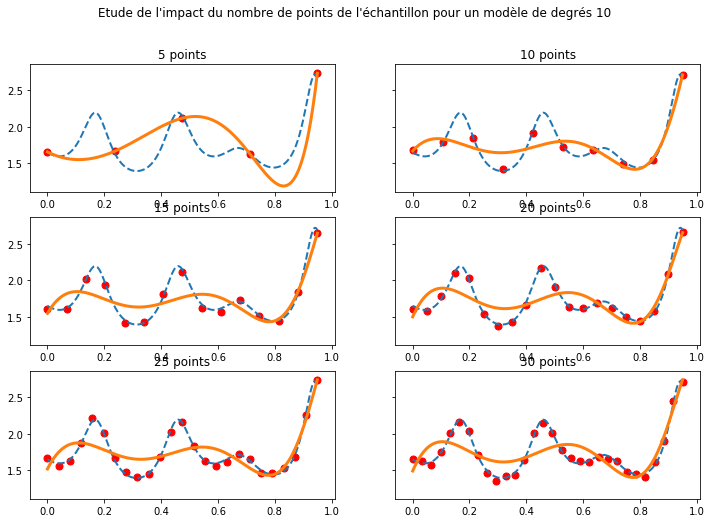

In [8]:
etude_points()

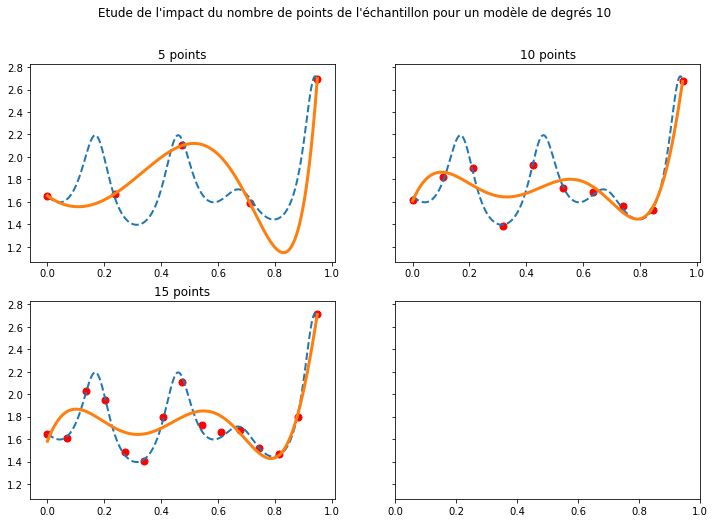

In [9]:
etude_points(nbs=(5, 10, 15))

## Alternative d'échantillonnage

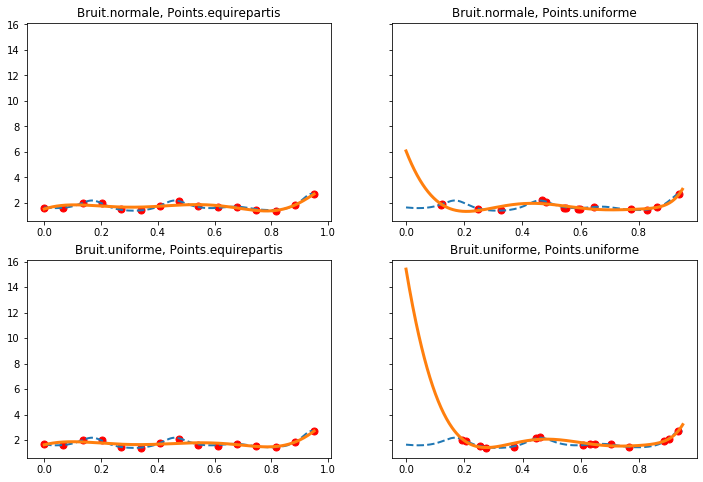

In [10]:
degres = 10
nb_points = 15
resultats = list()
for choix_bruit in lib.Bruit:
    for choix_points in lib.Points:
        echantillon = lib.genere_echantillon(
            cible=cible, 
            nb_points=nb_points, 
            choix_points=choix_points,
            choix_bruit=choix_bruit,
            amplitude=0.05,
        )
        modele = lib.ModelePolynomial(degres=degres)
        modele.entraine(echantillon)
        resultats.append((choix_points, choix_bruit, echantillon, modele))
        
fig, reps = plt.subplots(ncols=2, nrows=2, sharey=True)
for (cp, cb, ech, mod), rep in zip(resultats, reps.flatten()):
    lib.affichage_cible(cible=cible, repere=rep)
    lib.affichage_echantillon(echantillon=ech, repere=rep)
    mod.affichage(cible=cible, repere=rep)
    rep.set_title(f"{cb}, {cp}")
    

# Impact de la complexité du modèle à échantillon donné.

- Faire les courbes des fonctions qui au degrés associe l'erreur du modèle entrainé. (calculé via l'échantillon et via la cible)

In [11]:
def erreur_empirique(modele: lib.ModelePolynomial, echantillon: lib.Echantillon) -> float:
    return lib.erreur_quadratique(modele(echantillon.abcisses) - echantillon.ordonnees)

In [12]:
def erreur_objective(modele: lib.ModelePolynomial, cible: lib.Cible, np_points: int=500) -> float:
    x = np.linspace(cible.gauche, cible.droite, nb_points)
    return lib.erreur_quadratique(modele(x) - cible.fonction(x))

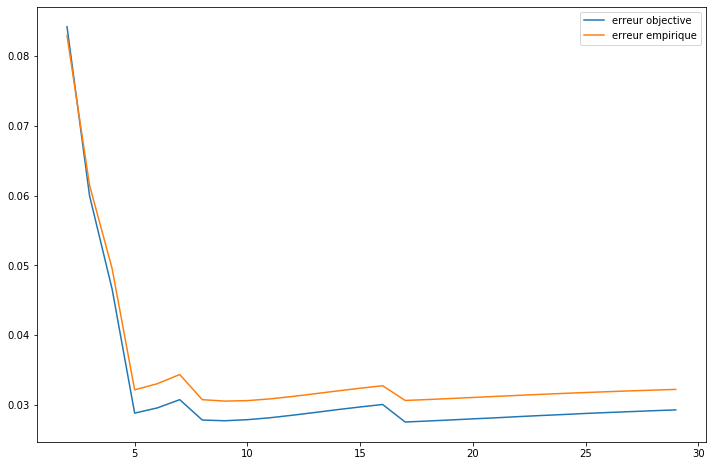

In [13]:
echantillon = lib.genere_echantillon(
    cible=cible, 
    nb_points=20, 
    choix_points=lib.Points.equirepartis, 
    choix_bruit=lib.Bruit.uniforme, 
    amplitude=0.01
)
degres = [i for i in range(2, 30)]
erreurs_objective = list()
erreurs_empirique = list()

for deg in degres:
    modele = lib.ModelePolynomial(degres=deg)
    modele.entraine(echantillon)
    erreurs_objective.append(erreur_objective(modele, cible))
    erreurs_empirique.append(erreur_empirique(modele, echantillon))

fig, rep = plt.subplots()
rep.plot(degres, erreurs_objective, label="erreur objective")
rep.plot(degres, erreurs_empirique, label="erreur empirique")
rep.legend()
    

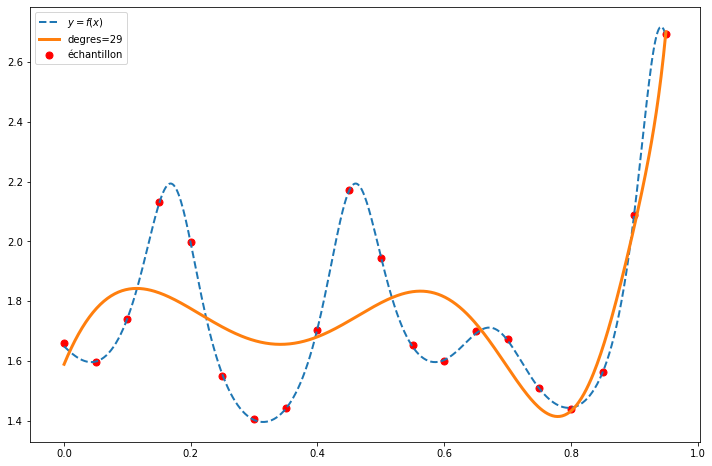

In [14]:
fig, rep = plt.subplots()
lib.affichage_cible(cible, rep)
lib.affichage_echantillon(echantillon, repere=rep)
modele.affichage(cible=cible, repere=rep)
rep.legend()